In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
from tensorflow.keras.applications import EfficientNetB0 # Pretrained convolutional neural network (CNN) from Keras. Good trade-off between speed and accuracy.
from tensorflow.keras.models import Model #  For creating custom models by combining layers.
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator #  Handles loading images, rescaling, and data augmentation.
from tensorflow.keras.optimizers import Adam # Optimizer for training (adaptive learning rate).

2025-10-24 08:27:12.640344: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761294432.885083      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761294432.963383      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


EfficientNetB0: Pretrained convolutional neural network (CNN) from Keras. Good trade-off between speed and accuracy.

Model: For creating custom models by combining layers.

Dense: Fully connected layer.

GlobalAveragePooling2D: Replaces flattening, reduces number of parameters, helps generalization.

ImageDataGenerator: Handles loading images, rescaling, and data augmentation.

Adam: Optimizer for training (adaptive learning rate).

### TASK: многоклассовая классификация (2 класса)


| Этап                           | Что происходит                                                                   |
| ------------------------------ | -------------------------------------------------------------------------------- |
| **ImageDataGenerator**         | Загружает изображения из папок и применяет аугментации                           |
| **EfficientNetB0**             | Предобученная модель, хорошо работает даже на небольших наборах                  |
| **Этап 1 (замороженные слои)** | Обучаем только верхние слои (чтобы сеть подстроилась под новую задачу)           |
| **Этап 2 (fine-tuning)**       | Размораживаем часть слоёв и немного дообучаем с малым `lr`                       |
| **Сохранение модели**          | Сохраняет финальную модель, чтобы можно было потом использовать для предсказаний |


In [4]:
# Пути к датасету
train_dir = "/kaggle/input/cup-mug-dataset/Cup-mug_data/train" #"/kaggle/input/cup-mug-dataset/Cup-mug_data/train"
val_dir = "/kaggle/input/cup-mug-dataset/Cup-mug_data/train"

# ===============================
# 1. Подготовка данных
# ===============================

train_datagen = ImageDataGenerator(
    rescale=1./255, # normalization
    # apply random transformations to make the model robust to variations: 
    #rotation_range=20,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #zoom_range=0.2,
    #horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255) # Only normalized, no augmentation


                                                
train_gen = train_datagen.flow_from_directory(
    train_dir,              # Loads images from subfolders (cup and mug = classes).
    target_size=(224, 224), # Resizes to 224×224 (EfficientNet default)
    batch_size=32,          # Creates batches of 32 images.
    class_mode='categorical' #  Converts labels to categorical one-hot vectors ([1, 0] for cup, [0, 1] for mug). т.к. у нас 2 класса (cup и mug)
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 900 images belonging to 2 classes.
Found 900 images belonging to 2 classes.


In [5]:
# Class name check
print("Classes:", train_gen.class_indices)

Classes: {'Cup': 0, 'Mugs': 1}


In [6]:
''''''
# ===============================
# 2. Model
#       - Pretrained on ImageNet.
#       - include_top=False → removes original classification layer.
#       - input shape: 224×224×3 (RGB images).
# ===============================

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(base_model.output) # Turns feature maps into a single vector.
x = Dense(128, activation='relu')(x)        # Fully connected hidden layer with 128 neurons, Rectified Linear Unit activation.
output = Dense(2, activation='softmax')(x)  # Output layer for 2 classes, returns probabilities

model = Model(inputs=base_model.input, outputs=output) # Combines base + custom layers into one model.


2025-10-24 08:27:34.857766: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
''''''
# Замораживаем базовые слои (первый этап — fine-tuning позже)
# Now we want to freeze pretrained layers → only train top Dense layers.
#     - It helps prevent overfitting on small dataset.
#     - Later can fine-tune some base layers.

for layer in base_model.layers:
    layer.trainable = False

# Complete the Model : 
#     - Optimizer: Adam with learning rate 0.001.
#     - Loss: Categorical crossentropy (for multi-class, here 2 classes).
#     - Metrics: Accuracy.


model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
''''''
# ===============================
# 3. Train the Model (этап 1)
# ===============================

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)

# ===============================
# 4. Fine-Tuning Размораживаем часть слоёв (этап 2 — тонкая настройка)
#     - Unfreeze last 30 layers → allow slight adjustment to dataset features.
#     - Lower learning rate 1e-4 → prevents destroying pretrained weights.
#     - Fine-tuning improves accuracy for specific dataset styles (drawings, photos, etc.).
# ===============================

for layer in base_model.layers[-10:]:  # размораживаем последние 30 слоёв
    layer.trainable = True

model.compile(optimizer=Adam(1e-2), loss='categorical_crossentropy', metrics=['accuracy'])

history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)

# ===============================
# 5. Save the Model
# ===============================

model.save("cup_mug_classifier.h5")
print("✅ Model saved: cup_mug_classifier.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.4784 - loss: 0.7296 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.4838 - loss: 0.7032 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.5121 - loss: 0.6957 - val_accuracy: 0.5000 - val_loss: 0.7032
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.5391 - loss: 0.6964 - val_accuracy: 0.5000 - val_loss: 0.6991
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.5106 - loss: 0.6939 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.5000 - loss: 0.6945 - val_accuracy: 0.5000 - val_loss: 0.6946
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5071 - loss: 0.6949

In [8]:
''''''

#  Diagnostic Cell
#   - inspect your data generator,
#   - verify normalization and label shapes,
#   - check your model’s last layer + loss consistency,
#   - and give a human-readable summary of what’s wrong (and how to fix it).

import numpy as np
import tensorflow as tf

print("🔍 Checking data generator and model configuration...\n")

# --- 1️⃣ Check generator
try:
    x_batch, y_batch = next(train_gen)
    print(f"✅ Generator loaded a batch: x shape = {x_batch.shape}, y shape = {y_batch.shape}")
    print(f"  - Pixel range: {x_batch.min():.2f} → {x_batch.max():.2f}")
    if x_batch.max() > 1.0:
        print("⚠️  Images not normalized! Add `rescale=1./255` in ImageDataGenerator.")

    print("  - Example labels:", y_batch[:5])
    if hasattr(train_gen, 'class_indices'):
        print("  - Class indices:", train_gen.class_indices)
    else:
        print("⚠️  Generator has no class_indices (check class_mode argument).")

except Exception as e:
    print("❌ Could not fetch batch from generator:", e)
    raise e

# --- 2️⃣ Check model output
print("\n🔍 Checking model output and loss setup...\n")

output_layer = model.layers[-1]
activation = getattr(output_layer, 'activation', None)
units = getattr(output_layer, 'units', None)

if activation:
    print(f"✅ Last layer activation: {activation.__name__}")
if units:
    print(f"✅ Output units: {units}")

loss = model.loss if hasattr(model, 'loss') else "N/A"
print(f"✅ Model loss function: {loss}")

# --- 3️⃣ Match analysis
issues = []

if len(y_batch.shape) == 2 and y_batch.shape[1] == 2:
    if not (units == 2 and activation.__name__ == 'softmax' and 'categorical' in str(loss)):
        issues.append("❌ For 2D one-hot labels, use `Dense(2, activation='softmax')` and `loss='categorical_crossentropy'`.")
elif len(y_batch.shape) == 1 or (len(y_batch.shape) == 2 and y_batch.shape[1] == 1):
    if not (units == 1 and activation.__name__ == 'sigmoid' and 'binary' in str(loss)):
        issues.append("❌ For binary labels, use `Dense(1, activation='sigmoid')` and `loss='binary_crossentropy'`.")
else:
    issues.append("⚠️ Unexpected label shape. Check your generator's class_mode ('binary' or 'categorical').")

# --- 4️⃣ Final summary
print("\n🧾 Summary:")
if issues:
    for issue in issues:
        print(issue)
else:
    print("✅ Model and data setup look consistent.")

print("\nTip: if accuracy still stays at 0.5, try a simple Conv2D model on a few images to confirm the data works.")



'\n\n#  Diagnostic Cell\n#   - inspect your data generator,\n#   - verify normalization and label shapes,\n#   - check your model’s last layer + loss consistency,\n#   - and give a human-readable summary of what’s wrong (and how to fix it).\n\nimport numpy as np\nimport tensorflow as tf\n\nprint("🔍 Checking data generator and model configuration...\n")\n\n# --- 1️⃣ Check generator\ntry:\n    x_batch, y_batch = next(train_gen)\n    print(f"✅ Generator loaded a batch: x shape = {x_batch.shape}, y shape = {y_batch.shape}")\n    print(f"  - Pixel range: {x_batch.min():.2f} → {x_batch.max():.2f}")\n    if x_batch.max() > 1.0:\n        print("⚠️  Images not normalized! Add `rescale=1./255` in ImageDataGenerator.")\n\n    print("  - Example labels:", y_batch[:5])\n    if hasattr(train_gen, \'class_indices\'):\n        print("  - Class indices:", train_gen.class_indices)\n    else:\n        print("⚠️  Generator has no class_indices (check class_mode argument).")\n\nexcept Exception as e:\n    

In [9]:
'''

from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import load_model

model = load_model("cup_mug_classifier.h5")

img_path = "/kaggle/input/cup-mug-dataset/Cup-mug_data/val/Mugs/images - 2022-03-30T103924.640.jpg"
img_path = "/kaggle/input/cup-mug-dataset/Cup-mug_data/val/Mugs/images - 2022-03-30T103924.745.jpg"
img_path = "/kaggle/input/cup-mug-dataset/Cup-mug_data/val/Cup/images - 2022-03-29T161200.713.jpg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) / 255.0

pred = model.predict(x)
classes = ['cup', 'mug']
print("Это:", classes[np.argmax(pred)])
'''

'\n\nfrom tensorflow.keras.preprocessing import image\nimport numpy as np\nfrom tensorflow.keras.models import load_model\n\nmodel = load_model("cup_mug_classifier.h5")\n\nimg_path = "/kaggle/input/cup-mug-dataset/Cup-mug_data/val/Mugs/images - 2022-03-30T103924.640.jpg"\nimg_path = "/kaggle/input/cup-mug-dataset/Cup-mug_data/val/Mugs/images - 2022-03-30T103924.745.jpg"\nimg_path = "/kaggle/input/cup-mug-dataset/Cup-mug_data/val/Cup/images - 2022-03-29T161200.713.jpg"\nimg = image.load_img(img_path, target_size=(224, 224))\nx = image.img_to_array(img)\nx = np.expand_dims(x, axis=0) / 255.0\n\npred = model.predict(x)\nclasses = [\'cup\', \'mug\']\nprint("Это:", classes[np.argmax(pred)])\n'

## Visualization

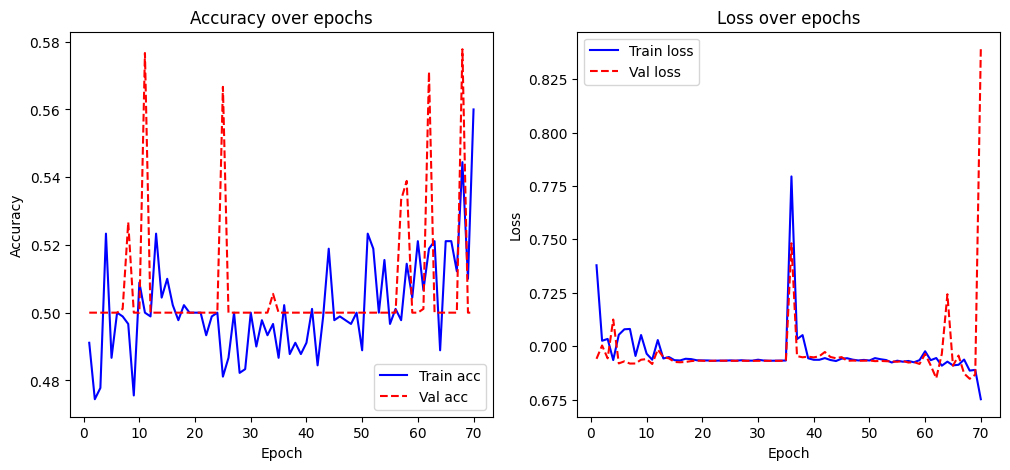

In [10]:
''''''
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# ===========================================
# 1. ВИЗУАЛИЗАЦИЯ ПРОЦЕССА ОБУЧЕНИЯ
# ===========================================

def plot_training(history1, history2=None):
    acc = history1.history['accuracy']
    val_acc = history1.history['val_accuracy']
    loss = history1.history['loss']
    val_loss = history1.history['val_loss']

    if history2:
        acc += history2.history['accuracy']
        val_acc += history2.history['val_accuracy']
        loss += history2.history['loss']
        val_loss += history2.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Train acc')
    plt.plot(epochs, val_acc, 'r--', label='Val acc')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Train loss')
    plt.plot(epochs, val_loss, 'r--', label='Val loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Вызов
plot_training(history, history_finetune)


In [11]:
'''
# ===========================================
# 2. ПРОВЕРКА НА СЛУЧАЙНЫХ 5 ИЗОБРАЖЕНИЯХ
# ===========================================

# Загружаем обученную модель
model = load_model("cup_mug_classifier.h5")

# Классы, как в train_gen.class_indices
classes = ['Cup', 'Mugs']

# Путь к валидационным изображениям
val_base_dir = "/kaggle/input/cup-mug-dataset/Cup-mug_data/val"

# Соберем список файлов
all_images = []
for label in classes:
    folder = os.path.join(val_base_dir, label)
    for img_name in os.listdir(folder):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            all_images.append((os.path.join(folder, img_name), label))

# Выберем 5 случайных изображений
samples = random.sample(all_images, 15)

plt.figure(figsize=(15, 10))

for i, (img_path, true_label) in enumerate(samples):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) / 255.0

    pred = model.predict(x)
    pred_label = classes[np.argmax(pred)]

    plt.subplot(3, 5, i+1)
    plt.imshow(image.load_img(img_path))
    plt.axis('off')
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)

plt.show()
'''

'\n# ===========================================\n# 2. ПРОВЕРКА НА СЛУЧАЙНЫХ 5 ИЗОБРАЖЕНИЯХ\n# ===========================================\n\n# Загружаем обученную модель\nmodel = load_model("cup_mug_classifier.h5")\n\n# Классы, как в train_gen.class_indices\nclasses = [\'Cup\', \'Mugs\']\n\n# Путь к валидационным изображениям\nval_base_dir = "/kaggle/input/cup-mug-dataset/Cup-mug_data/val"\n\n# Соберем список файлов\nall_images = []\nfor label in classes:\n    folder = os.path.join(val_base_dir, label)\n    for img_name in os.listdir(folder):\n        if img_name.lower().endswith((\'.png\', \'.jpg\', \'.jpeg\')):\n            all_images.append((os.path.join(folder, img_name), label))\n\n# Выберем 5 случайных изображений\nsamples = random.sample(all_images, 15)\n\nplt.figure(figsize=(15, 10))\n\nfor i, (img_path, true_label) in enumerate(samples):\n    img = image.load_img(img_path, target_size=(224, 224))\n    x = image.img_to_array(img)\n    x = np.expand_dims(x, axis=0) / 255.0\n\n 

In [12]:
#  Make sure labels are correct one-hot vectors.

imgs, labels = next(train_gen)
print(imgs.shape)  # (batch_size, 224, 224, 3)
print(labels.shape)  # (batch_size, 2)
print(labels[:5])

(32, 224, 224, 3)
(32, 2)
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


# Effect of fine-tuning

In [13]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def create_model(unfreeze_layers=0):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
    
    # Freeze all layers first
    for layer in base_model.layers:
        layer.trainable = False
    
    # Unfreeze last `unfreeze_layers` layers
    if unfreeze_layers > 0:
        for layer in base_model.layers[-unfreeze_layers:]:
            layer.trainable = True
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)  # 40% neurons randomly ignored during training
    output = Dense(2, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    #model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_gen, validation_data=val_gen, epochs=35)

    return model


### Train with different numbers of layers

In [ ]:
unfreeze_options = [0, 10, 30, 50]  # 0 = only top layers, 10 = last 10 layers, etc.
histories = {}

for n in unfreeze_options:
    print(f"\n=== Training with last {n} layers unfrozen ===")
    model = create_model(unfreeze_layers=n)
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=35,
        verbose=1
    )
    histories[n] = history



=== Training with last 0 layers unfrozen ===
Epoch 1/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.4708 - loss: 0.7500 - val_accuracy: 0.5000 - val_loss: 0.7046
Epoch 2/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.4879 - loss: 0.7178 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.4968 - loss: 0.6959 - val_accuracy: 0.5000 - val_loss: 0.6950
Epoch 4/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.5100 - loss: 0.6944 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.5037 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.4982 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 7/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.4808 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.4924 - l

#### Plot accuracy vs fine-tuning

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for n, history in histories.items():
    val_acc = history.history['val_accuracy']
    plt.plot(range(1,len(val_acc)+1), val_acc, marker='o', label=f'unfreeze {n} layers')

plt.title('Validation Accuracy vs Fine-Tuning Depth')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()


If model isn’t learning:
  - If your learning rate is too high, the optimizer may overshoot minima → model fails to learn.
  - If too low, model barely updates weights → accuracy stays the same.

### Train with different numbers of neurons

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def create_model(neurons=128, unfreeze_layers=30):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
    
    # Freeze all layers first
    for layer in base_model.layers:
        layer.trainable = False
    
    # Optionally unfreeze last `unfreeze_layers` layers
    if unfreeze_layers > 0:
        for layer in base_model.layers[-unfreeze_layers:]:
            layer.trainable = True
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(neurons, activation='relu')(x)
    x = Dropout(0.4)(x)
    output = Dense(2, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    
    #model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_gen, validation_data=val_gen, epochs=35)


    return model


In [ ]:
neuron_options = [64, 128, 256, 512]
histories = {}

for n in neuron_options:
    print(f"\n=== Training with Dense layer of {n} neurons ===")
    model = create_model(neurons=n, unfreeze_layers=30)
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=35,
        verbose=1
    )
    histories[n] = history


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for n, history in histories.items():
    val_acc = history.history['val_accuracy']
    plt.plot(range(1,len(val_acc)+1), val_acc, marker='o', label=f'{n} neurons')

plt.title('Validation Accuracy vs Number of Neurons')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()
